# NB2. Forecasting Philippine Trade Activity using local and global forecasting models: Single-Task Learning

*Borromeo, Castanares, Garcia, Tan*

`"It ain't about how hard you hit. It's about how hard you can get hit and keep moving forward; how much you can take and keep moving forward. That's how winning is done!"
-Rocky Balboa`

In [1]:
%%capture
!pip install statsforecast
!pip install mlforecast
!pip install utilsforecast
!pip install tsfeatures
!pip install lightgbm
!pip install neuralforecast

In [2]:
%%capture
!pip uninstall -y torch torchvision
!pip install torch torchvision

In [ ]:
### Restart Kernel/Session at the point but skip the pip install

In [1]:
from statsforecast import StatsForecast
from statsforecast.models import *

from utilsforecast.feature_engineering import trend, fourier, pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

#from mlforecast.target_transforms import Differences
#from mlforecast import MLForecast
#import lightgbm as lgb

from functools import partial
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
import os
import time
from IPython.display import clear_output
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DIR = '/content/drive/MyDrive/AIM/Timeseries/FinalProject'
else:
    DIR = '.'

plt.style.use("ggplot")

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

pd.set_option("display.precision", 3)
np.set_printoptions(suppress=True)

Mounted at /content/drive


### 1.0 Data Preprocessing, Train/Test split

In [2]:
# Setup
select = 'PHL'

### Consolidate Import and Export data
DAT_Export = pd.read_csv(f'{DIR}/data/SPGlobal_Exports_clean.csv',
                         parse_dates=['ds'])
DAT_Export.dropna(axis=0, inplace=True)
DAT_Export.columns = [f'{x}_export' if x != 'ds' else x for x in DAT_Export.columns]
DAT_Export = DAT_Export.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)


DAT_Import = pd.read_csv(f'{DIR}/data/SPGlobal_Imports_clean.csv', parse_dates=['ds'])
DAT_Import.dropna(axis=0, inplace=True)
DAT_Import.columns = [f'{x}_import' if x != 'ds' else x for x in DAT_Import.columns]
DAT_Import = DAT_Import.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)

df_FX = pd.read_excel(f'{DIR}/data/uscross_clean.xlsx',parse_dates=['Date'])#[['Date','PHL']]
#rename column
df_FX = df_FX.rename(columns = {'Date':'ds'})
df_FX.set_index('ds', inplace=True)
df_FX = 1.0/df_FX
df_FX.columns = [f'{x}_FX' if x != 'ds' else x for x in df_FX.columns]
df_FX = (df_FX
        .loc[:'2025-03-01',:]
        .reset_index()
        .melt(id_vars=['ds'],
              var_name='unique_id',
              value_name='y',
              ignore_index=True)
              )

DAT = pd.concat([DAT_Export, DAT_Import, df_FX], axis=0)
DAT.query('ds.dt.year >= 2024').reset_index(drop=True).to_csv(f'TEST.csv')
DAT.query('ds.dt.year < 2024').reset_index(drop=True).to_csv(f'TRAIN.csv')


TRAIN = pd.read_csv(f'TRAIN.csv',index_col=0,parse_dates=['ds'])
TEST = pd.read_csv(f'TEST.csv',index_col=0,parse_dates=['ds'])

display(TRAIN)
print(f'TRAIN: N = {TRAIN.ds.nunique()} observations/unique_id')
display(TEST)
print(f'TEST: N = {TEST.ds.nunique()} observations/unique_id')

,ds,unique_id,y
0,2010-01-01,AUS_export,618.538
1,2010-02-01,AUS_export,613.971
2,2010-03-01,AUS_export,699.770
3,2010-04-01,AUS_export,769.386
4,2010-05-01,AUS_export,829.484
...,...,...,...
9067,2023-08-01,AED_FX,3.673
9068,2023-09-01,AED_FX,3.673
9069,2023-10-01,AED_FX,3.673
9070,2023-11-01,AED_FX,3.673


TRAIN: N = 168 observations/unique_id


,ds,unique_id,y
0,2024-01-01,AUS_export,1634.895
1,2024-02-01,AUS_export,1546.835
2,2024-03-01,AUS_export,1642.202
3,2024-04-01,AUS_export,1542.990
4,2024-05-01,AUS_export,1660.744
...,...,...,...
805,2024-11-01,AED_FX,3.673
806,2024-12-01,AED_FX,3.673
807,2025-01-01,AED_FX,3.673
808,2025-02-01,AED_FX,3.673


TEST: N = 15 observations/unique_id


* The datasets (Imports, Exports, FX) were split into TRAIN (N=168 observations/series) and TEST (N=15 observations/series).
* Note that we now included data from other countries which will be a pre-cursor for Multi-task learning (next notebook).
* This notebook on applying different single-task learning models to Philippines.
* We have also included STL models for other countries (see Appendix).

In [3]:
#This is for cross-validation
HORIZON = 15 # months for test set
HORIZON_cv = 6 # 6 months for CV
step_size = 3 # publication of data is 3 months
n_windows = 3
season_length = 12 # months
LOG = {}  # variable to store important outputs

### 2.0 Baseline models
We explore several statistical and Machine Learning models for STL as baseline.
We considered models that could capture the strong strength of trend of the Export/Import/FX series.


##### 2.1 Model parameters
The list below enumerates the models and the chosen model parameters.
* Naive
* Random Walk with Drift
* ETS (Auto)
* ARIMA (Auto)
    - d=1 (first difference) was set to remove the trend and make the series stationary
* Random Forest Regressor
    - n = 50 trees (user-defined)
* Light Gradient Boosting
    - n = 50 trees (user-defined)
* Long-Short Term Memory Neural Network
    - input_size = 2 * 15 months (user-defined)
    - hidden_size = 128 neurons
    - encoder/decoder layers = 2
    - recurrent = True

We then select several best candidates for the baseline Single-Task models.

In [4]:
from statsforecast import StatsForecast
from statsforecast.models import *
from utilsforecast.feature_engineering import trend, fourier, pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from statsforecast.models import ARIMA,AutoARIMA
from statsforecast.utils import ConformalIntervals

intervals = ConformalIntervals(h=HORIZON, n_windows=100)
stats_models = [
    # Baseline
    Naive(),RandomWalkWithDrift(),
    # ETS
    AutoETS(season_length=season_length, model="AAA", alias="ETS_additive"),
    AutoETS(season_length=season_length, model="MAM", alias="ETS_multiplicative"),
]

arima_models = [
    AutoARIMA(alias="arima", d=1, season_length=12),
]

dhr_models = [
    AutoARIMA(season_length=season_length, d=1, alias="DHR-ARIMA")
]

#Force ml and neural models to run under collab environment only
ml_models = []
nn_models = []

futr_exog_list = ['sin1_12','sin2_12','cos1_12','cos2_12']
hist_exog_list = ['PHL_FX','sin1_12','sin2_12','cos1_12','cos2_12']
if IN_COLAB:
    import lightgbm as lgb
    from neuralforecast.losses.pytorch import DistributionLoss
    from neuralforecast.models import LSTM
    from mlforecast import MLForecast

    ml_models = [
        RandomForestRegressor(n_estimators=50, random_state=42),
        lgb.LGBMRegressor(verbose=-1, n_estimators=50, random_state=42),
    ]

    nn_models = [

        LSTM(h=HORIZON_cv,
                input_size=2*HORIZON,
                loss=DistributionLoss(distribution="Normal", level=[80, 95]),
                scaler_type='robust',
                encoder_n_layers=2,
                encoder_hidden_size=128,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_steps=200,
                futr_exog_list=futr_exog_list,
                stat_exog_list=[],
                recurrent=True,
                h_train=1,
                )
    ]

INFO:lightning_fabric.utilities.seed:Seed set to 1


##### 2.2 Evaluation Metrics
We included Mean Directional Accuracy (MDA) as part our of evaluation metrics.
MDA captures the proportion of the time that the forecast, $F_t$, correctly predicted the direction of the actual time series, $A_t$.

\begin{align*}
    MDA = \frac{1}{N}\sum{\left[sign(A_t - A_{t-1}) == sign(F_t - F_{t-1})\right]}
\end{align*}

The main evaluation metrics that will be used to assess the best models are:
* MAE - This provided direct link about the forecast error (how far is the forecast off in Billion USD?)
* MDA - For economist, this is important to assess whether the model tracks the trend of the import/export activity. It will also help inform if there is a systematic bias in the forecasts.
* Prediction intervals - Do the prediction intervals cover the range of actual value or is the model confidently wrong in its forecast.


In [6]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape as _mape, mase, rmsse

def mape(df, models, id_col = "unique_id", target_col = "y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape

def mda(df, models, id_col = "unique_id", target_col="y"):
    #mean directional accuracy
    slope = df.loc[:,[target_col] + models].diff().dropna()
    y = slope[target_col].values
    out = {}
    out['unique_id'] = df[id_col].iloc[0]
    for model in models:
        xx = slope[model].values
        out[f'{model}'] = np.mean(np.sign(xx) == np.sign(y))

    return pd.Series(out).to_frame().T

def calculate_yoy_equivalent(df_TRAIN = [],
                             fc_regular = []):
    '''Given the training and forecast dataframes,
    this function calculates the year-on-year (YoY) equivalent
    of the forecasted values and associated errors

    parameters
    ----------
    df_TRAIN : pd.DataFrame
        The training dataframe containing historical data.
    fc_regular : pd.DataFrame
        The forecast dataframe containing predicted values.

    returns
    -------
    fc_gr: pd.DataFrame
        The year-on-year equivalent of the forecasted values and associated errors.

    errors: pd.DataFrame
        The errors associated with the year-on-year equivalent forecasts.

    '''

    test_idx = fc_regular.index


    temp = (df_TRAIN
            .query('unique_id == @select')
           .set_index('ds')
           .copy())

    # reconstruct_series
    standard_col = ['unique_id','ds','y']
    model_var = [x for x in fc_regular.columns if x not in standard_col]

    for col in model_var:
        temp[col] = temp['y']

    #joined
    fc_gr = (temp.T
                .join(fc_regular.T, how='outer')
                .drop('unique_id')
                .T
                .pct_change(periods=12).dropna()*100.)
    fc_gr['unique_id'] = select

    df_train_gr = df_train.copy()
    df_train_gr['y'] = df_train_gr['y'].pct_change(periods=12)*100.
    df_train_gr.dropna(inplace=True)

    fc_gr_test = fc_gr.loc[test_idx,:].copy()
    errors = evaluate(fc_gr_test.reset_index(),
                metrics=metrics,
                train_df=df_train_gr).drop('unique_id',axis=1).set_index('metric')

    return fc_gr, errors

metrics = [mae, mape, rmse,
           partial(mase, seasonality=season_length),
           partial(rmsse, seasonality=season_length),
           mda]

##### 2.3 Feature Augmentation
We included time features (trend/age and fourier series (12 month seasonality)) and FX as additional exogenous variables.
For FX, the last FX rate was used as the future value for the next 15 months.

In [18]:
#create augmented df for cross-val and testing
features = [trend,
            partial(fourier, season_length=12, k=2)
            ]

TRAIN_aug, future_predictors = pipeline(df=TRAIN,
                                           features=features,
                                           freq="MS",
                                           h=HORIZON)

#add PHL_FX as exogeneous
ref = df_FX.query("unique_id == 'PHL_FX'").set_index('ds')['y'].to_dict()
TRAIN_aug['PHL_FX'] = [ref[date] for date in TRAIN_aug.ds]

#take the last FX rate as future predictor - strong assumption
future_predictors['PHL_FX'] = TRAIN_aug['PHL_FX'].iloc[-1]

print('*'*75)
print('Table. Augmented Features')
display(TRAIN_aug.query("unique_id == 'PHL_export'").tail())
print('*'*75)
print('Table. Future Predictors')
display(future_predictors.tail())

***************************************************************************
Table. Augmented Features


,ds,unique_id,y,trend,sin1_12,sin2_12,cos1_12,cos2_12,PHL_FX
1843,2023-08-01,PHL_export,379.183,164.0,-8.660e-01,8.660e-01,-5.000e-01,-0.5,56.160
1844,2023-09-01,PHL_export,384.462,165.0,-1.000e+00,-1.709e-06,8.544e-07,-1.0,56.787
1845,2023-10-01,PHL_export,370.253,166.0,-8.660e-01,-8.660e-01,5.000e-01,-0.5,56.789
1846,2023-11-01,PHL_export,347.342,167.0,-5.000e-01,-8.660e-01,8.660e-01,0.5,55.812
1847,2023-12-01,PHL_export,321.057,168.0,5.309e-06,1.062e-05,1.000e+00,1.0,55.588


***************************************************************************
Table. Future Predictors


,unique_id,ds,trend,sin1_12,sin2_12,cos1_12,cos2_12,PHL_FX
805,YEN_FX,2024-11-01,179.0,-5.000e-01,-8.660e-01,8.660e-01,0.5,55.588
806,YEN_FX,2024-12-01,180.0,2.385e-07,4.770e-07,1.000e+00,1.0,55.588
807,YEN_FX,2025-01-01,181.0,5.000e-01,8.660e-01,8.660e-01,0.5,55.588
808,YEN_FX,2025-02-01,182.0,8.660e-01,8.660e-01,5.000e-01,-0.5,55.588
809,YEN_FX,2025-03-01,183.0,1.000e+00,-9.386e-06,-4.693e-06,-1.0,55.588


### 3.0 Cross-validation all series
We do cross-validation to find the best model for modelling PHL export and import activity.


In [19]:
start = time.time()
select = ['PHL_export', 'PHL_import']
df_train = TRAIN.query('unique_id in @select')
df_train_aug = TRAIN_aug.query('unique_id in @select')

#### Stats and Baseline models
sf_stats = StatsForecast(stats_models, freq='MS', n_jobs=-1)
fc_stats_cv = sf_stats.cross_validation(h=HORIZON_cv,
                                         n_windows=n_windows,
                                         df=df_train,
                                         step_size=step_size)

#Dynamic Regression
# We skip DR as it raises the need to assume
# the future FX rate
# sf_dynamic = StatsForecast(dhr_models, freq='MS', n_jobs=-1)
# fc_dynamic_cv = sf_dynamic.cross_validation(h=HORIZON_cv,
#                                             n_windows=n_windows,
#                                             df=df_train_aug,
#                                             step_size=HORIZON)

#### AUTO-ARIMA models
sf_arima = StatsForecast(arima_models, freq='MS', n_jobs=-1)
fc_arima_cv = sf_arima.cross_validation(h=HORIZON_cv,
                                         n_windows=n_windows,
                                         df=df_train,
                                         step_size=step_size,
                                         #prediction_intervals=intervals,
                                         #level=[80, 95]
                                         )

#### ML MODELS
mf_cv = pd.DataFrame([])
if ml_models != []:

    mf = MLForecast(ml_models, freq="MS")
    mf_cv = mf.cross_validation(
        df=df_train_aug,
        h=HORIZON_cv,
        n_windows=n_windows,
        static_features = [],
        step_size=step_size,
    )

#### NN MODELS
nf_cv = pd.DataFrame([])
if nn_models != []:
    from neuralforecast import NeuralForecast

    nf = NeuralForecast(nn_models, freq="MS")
    nf_cv = nf.cross_validation(
        df=df_train_aug,
        n_windows=n_windows,
        step_size=step_size, # This ensures non-overlapping test sets
        refit=False # Set to True to retrain the model on each new window, but this is much slower
    )

#### Merge results
common_cols = ['unique_id', 'ds', 'cutoff', 'y']
cv_all = (fc_stats_cv
        .merge(fc_arima_cv, on=common_cols, how='outer')
        #.merge(fc_dynamic_cv, on=common_cols, how='outer')
)

if not(mf_cv.empty):
    cv_all = cv_all.merge(mf_cv, on=common_cols, how='outer')
if not(nf_cv.empty):
    cv_all = cv_all.merge(nf_cv, on=common_cols, how='outer')

print(f'Elapsed time: {time.time() - start:.2f} seconds')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Elapsed time: 19.34 seconds


In [20]:
#### Evaluate the cross-validated results
cv_eval = evaluate(cv_all.drop('cutoff', axis=1),
         metrics=metrics,
         train_df=df_train)

grp = (cv_eval
       .groupby('unique_id')
)
collect = []
for id, group in grp:
    best_model = (group
                .set_index('metric')
                .loc['mae',:]
                .drop('unique_id')
                .sort_values()
                .index)[0]
    entry = {'unique_id': id.split('/')[-1],
              'Best_model': best_model}
    entry.update(group[['metric', best_model]]
                 .set_index('metric')
                 .iloc[:,0]
                 .to_dict())
    collect.append(entry)

result_cv = pd.DataFrame.from_records(collect)

LOG['cv_bestmodels'] = (result_cv[['unique_id','Best_model']]
                        .set_index('unique_id')
                        .to_dict()['Best_model'])

#### display results
print('*'*75)
print('Table. CV evaluation across models by MAE')
display(cv_eval.query('metric == "mae"').T)

print('*'*75)
print('Table. Best models by MAE')
display(result_cv)

***************************************************************************
Table. CV evaluation across models by MAE


,0,1
unique_id,PHL_export,PHL_import
metric,mae,mae
Naive,30.469,38.792
RWD,30.111,40.677
ETS_additive,33.102,28.064
ETS_multiplicative,20.423,49.76
arima,31.184,29.217
RandomForestRegressor,142.669,96.984
LGBMRegressor,158.279,82.323
LSTM,38.997,97.671


***************************************************************************
Table. Best models by MAE


,unique_id,Best_model,mae,mape,rmse,mase,rmsse,mda
0,PHL_export,ETS_multiplicative,20.423,6.678,28.299,0.702,0.727,0.486
1,PHL_import,ETS_additive,28.064,4.978,34.886,0.458,0.416,NaN


**Insights**
* The cross-validation results show that both ETS models show the minimal MAE across the tested baseline models.
* The other candidate model is ARIMA.
* Surprisingly, ML models (RandomForestRegressor, LGBM, and LSTM) performed worst that Naive.
* Poor performance of ML models could be attributed to limited training data (158 observations)
* Intuitively, ETS is also a simple model capable of capturing strong trend in the series.
* The MAE were 20.4 (Export) and 28 (Import) Billion USD.

In [21]:
#### Store and display the results
LOG['baseline_cveval'] = cv_eval
print(cv_eval.T.columns)
cv_eval.T

RangeIndex(start=0, stop=11, step=1)


,0,1,2,3,4,5,6,7,8,9,10
unique_id,PHL_export,PHL_import,PHL_export,PHL_import,PHL_export,PHL_import,PHL_export,PHL_import,PHL_export,PHL_import,PHL_export
metric,mae,mae,mape,mape,rmse,rmse,mase,mase,rmsse,rmsse,mda
Naive,30.469,38.792,9.479,6.805,37.437,45.289,1.048,0.633,0.961,0.541,0.086
RWD,30.111,40.677,9.465,7.172,37.965,49.171,1.035,0.664,0.975,0.587,0.2
ETS_additive,33.102,28.064,10.437,4.978,41.485,34.886,1.138,0.458,1.065,0.416,0.429
ETS_multiplicative,20.423,49.76,6.678,8.789,28.299,56.872,0.702,0.812,0.727,0.679,0.486
arima,31.184,29.217,9.851,5.183,39.39,35.265,1.072,0.477,1.011,0.421,0.457
RandomForestRegressor,142.669,96.984,42.877,16.36,146.063,102.159,4.905,1.583,3.75,1.219,0.371
LGBMRegressor,158.279,82.323,47.576,13.837,161.459,87.442,5.442,1.344,4.146,1.044,0.314
LSTM,38.997,97.671,12.755,16.964,55.977,122.076,1.341,1.594,1.437,1.457,0.371


### 4.0 TEST Evaluation: Forecast 15 months ahead

In [22]:
#### Forecast the next 15 months
start = time.time()
select = ['PHL_export', 'PHL_import']
df_train = TRAIN.query('unique_id in @select')
df_train_aug = TRAIN_aug.query('unique_id in @select')
df_futr = future_predictors.query('unique_id in @select')


sf_stats = StatsForecast(stats_models, freq='MS', n_jobs=-1)
fc_stats = sf_stats.forecast(h=HORIZON,
                             df=df_train)
sf_dynamic = StatsForecast(dhr_models, freq='MS', n_jobs=-1)
fc_dynamic = sf_dynamic.forecast(h=HORIZON,
                                 X_df = df_futr,
                                 df=df_train_aug)
sf_arima = StatsForecast(arima_models, freq='MS', n_jobs=-1)
fc_arima = sf_arima.forecast(h=HORIZON,
                                df=df_train)

fc_ml = pd.DataFrame([])
if ml_models != []:
    mf = MLForecast(ml_models, freq="MS")
    mf.fit(df_train_aug, static_features=[])
    fc_ml = mf.predict(X_df=df_futr,
                        h=HORIZON,)
fc_nn = pd.DataFrame([])
if nn_models != []:
    nf = NeuralForecast(nn_models, freq="MS")
    nf.fit(df_train_aug)
    fc_nn = nf.predict(
        futr_df = df_futr,
    )




#### Merge results
common_cols = ['unique_id', 'ds']
fc_all = (fc_stats
         .merge(fc_arima, on=common_cols, how='outer')
         .merge(fc_dynamic, on=common_cols, how='outer')
)
if not(fc_ml.empty):
    fc_all = fc_all.merge(fc_ml, on=common_cols, how='outer')
if not(fc_nn.empty):
    fc_all = fc_all.merge(fc_nn, on=common_cols, how='outer')
df_test = TEST.query('unique_id in @select')
fc_all = fc_all.merge(df_test, on=['unique_id', 'ds'], how='outer')




#### Evaluate the Errors
#take only the best models from cross-validation
test_eval = evaluate(fc_all,
        metrics=metrics,
        train_df=df_train)
grp = test_eval.groupby('unique_id')
collect = []
for id, group in grp:
    tmp = {}
    tmp['unique_id'] = id
    best_model = LOG['cv_bestmodels'].get(id, 'Naive')
    tmp['best_model'] = best_model
    tmp.update(group.set_index('metric')[best_model].to_dict())
    collect.append(tmp)




#### Store and display results
clear_output()
test_eval_best = pd.DataFrame.from_records(collect)
LOG['baseline_testeval_all']  = test_eval
LOG['baseline_testeval_best'] = test_eval_best

print(f'Elapsed time: {time.time() - start:.2f} seconds')
test_eval_best

Elapsed time: 12.77 seconds


,unique_id,best_model,mae,mape,rmse,mase,rmsse,mda
0,PHL_export,ETS_multiplicative,20.378,5.832,25.028,0.701,0.643,0.5
1,PHL_import,ETS_additive,38.864,6.123,49.960,0.634,0.596,NaN


In [23]:
key_metrics = ['mae','mda']
test_eval.query('metric in @key_metrics').T

,0,1,10
unique_id,PHL_export,PHL_import,PHL_export
metric,mae,mae,mda
Naive,32.559,60.36,0.0
RWD,25.3,49.68,0.6
ETS_additive,20.281,38.864,0.5
ETS_multiplicative,20.378,32.039,0.5
arima,28.117,48.128,0.5
DHR-ARIMA,21.977,39.727,0.5
RandomForestRegressor,98.355,156.117,0.4
LGBMRegressor,95.284,159.188,0.4


*Note*:
* For Exports, ETS_additive showed the better MAE compared to the ETS_multiplicative (best model from cross-validation).
* Nevertheless, ETS models show robust performance on both cross-validation and test.
* Suprisingly, LSTM models performed well on the test set.
* Further investigation has to be made as to the robustness of LSTM in the cross-validation and test set.

#### Visualization of results

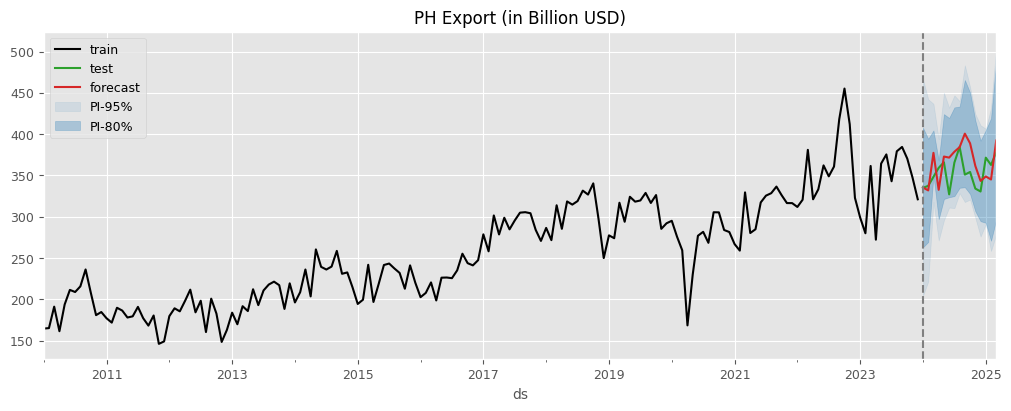

In [24]:
#plot the results
stats_models = [
    # ETS
    AutoETS(season_length=season_length, model="AAA", alias="ETS_additive"),
    AutoETS(season_length=season_length, model="MAM", alias="ETS_multiplicative"),
]

intervals = ConformalIntervals(h=HORIZON, n_windows=7)

#forecast both import and export
select = ['PHL_export', 'PHL_import']
df_train = TRAIN.query('unique_id in @select')
sf_stats = StatsForecast(stats_models, freq='MS', n_jobs=-1)
fc_stats = sf_stats.forecast(h=HORIZON,
                             df=df_train,
                             prediction_intervals=intervals,
                             level=[80,95])
fc_stats

def proc_plot_series_cv(TRAIN_series,
                        df_cv,
                        tag = 'arima',
                        with_PI = True):
    '''The functions plots the results of the
    cross-validation at different cutoff period

    parameters
    ----------
    TRAIN_series: pd.Series
        The training time series data.
    df_cv: pd.DataFrame
        The cross-validation results from NIXTLA
    tag: str
        The tag for the model.
    '''
    fig, ax = plt.subplots()
    #TRAIN.query('unique_id == @select').set_index('ds').loc[:,'y'].plot(ax=ax, label='train', color='black')
    TRAIN_series.plot(ax=ax, label='train', color='black')
    if 'cutoff' in df_cv.columns:
        for i, cutoff in enumerate(df_cv.cutoff.unique()):
            df_cut = df_cv.query('cutoff == @cutoff')
            df_cut = df_cut.set_index('ds')
            df_cut[tag].plot(ax=ax, color='tab:blue')
            if with_PI:
                ax.fill_between(df_cut.index, df_cut[f'{tag}-lo-95'], df_cut[f'{tag}-hi-95'], color='tab:blue', alpha = 0.1)
                ax.fill_between(df_cut.index, df_cut[f'{tag}-lo-80'], df_cut[f'{tag}-hi-80'], color='tab:blue', alpha = 0.3)

    return

def plot_traintest(TRAIN_series = [],
                   TEST_series = [],
                   df_forecast = [],
                   TAG = '',
                   title = '',
                   with_PI = True):

    fig, ax = plt.subplots()
    TRAIN_series.plot(ax=ax, label='train', color='black')
    TEST_series.plot(ax=ax, label='test', color='tab:green')
    df_forecast[TAG].plot(ax=ax, label='forecast',color='tab:red')
    if with_PI:
        ax.fill_between(df_forecast.index, df_forecast[f'{TAG}-lo-95'], df_forecast[f'{TAG}-hi-95'], label='PI-95%', color='tab:blue', alpha = 0.1)
        ax.fill_between(df_forecast.index, df_forecast[f'{TAG}-lo-80'], df_forecast[f'{TAG}-hi-80'], label='PI-80%', color='tab:blue', alpha = 0.3)
        ax.axvline(x=df_forecast.index[0],linestyle='--',color='grey')
    ax.set_title(title)
    ax.legend()
    return

select = 'PHL_export'
TRAIN_series = df_train.query('unique_id == @select').set_index('ds').loc[:,'y']
TEST_series  = TEST.query('unique_id == @select').set_index('ds').loc[:,'y']
df_forecast = fc_stats.query('unique_id == @select').set_index('ds')
TAG = 'ETS_multiplicative'

plot_traintest(TRAIN_series = TRAIN_series,
                   TEST_series = TEST_series,
                   df_forecast = df_forecast,
                   TAG = TAG,
                   title = 'PH Export (in Billion USD)',
                   with_PI = True)


**Insights**:
* ETS model show a robust forecast with actual values within 80% PI.
* ETS was able to track the export value 66 percent of the time (MDA = 0.66)

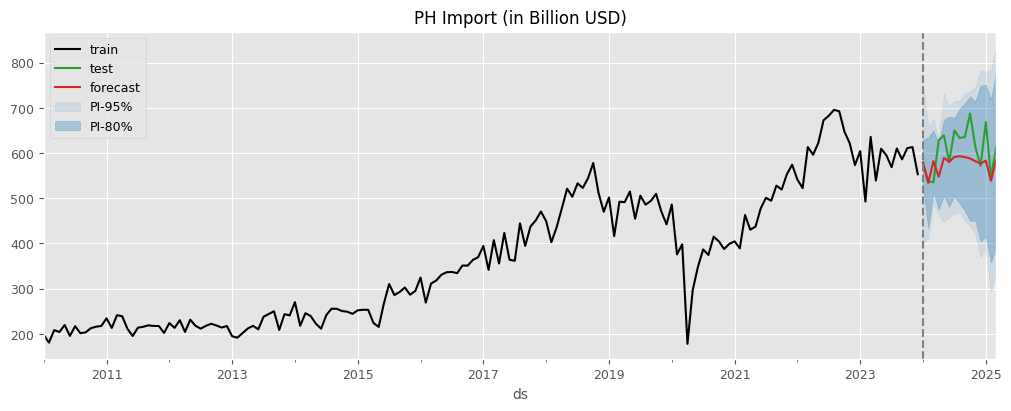

In [25]:
select = 'PHL_import'
TRAIN_series = df_train.query('unique_id == @select').set_index('ds').loc[:,'y']
TEST_series  = TEST.query('unique_id == @select').set_index('ds').loc[:,'y']
df_forecast = fc_stats.query('unique_id == @select').set_index('ds')
TAG = 'ETS_additive'

plot_traintest(TRAIN_series = TRAIN_series,
                   TEST_series = TEST_series,
                   df_forecast = df_forecast,
                   TAG = TAG,
                   title = 'PH Import (in Billion USD)',
                   with_PI = True)

**Insights**:
* ETS model show a robust forecast with actual values within 80% PI.
* Notably the PI of the model is large suggesting high forecast uncertainty.
* We examine if we can further improve the PI in MTL (see NB3)

### 5.0 Residual Diagnostics

We check the residuals of the test forecast for possible bias and serial correlation.

* Presence of residual bias could indicate ommitted variable error;
* Serial correlation of residuals and its lags could indicate that there is still signal component not captured by the model.

Table. Descriptive Statistics


,residual
count,15.000
mean,-10.665
std,23.437
min,-49.606
25%,-28.268
50%,-12.814
75%,2.937
max,26.578


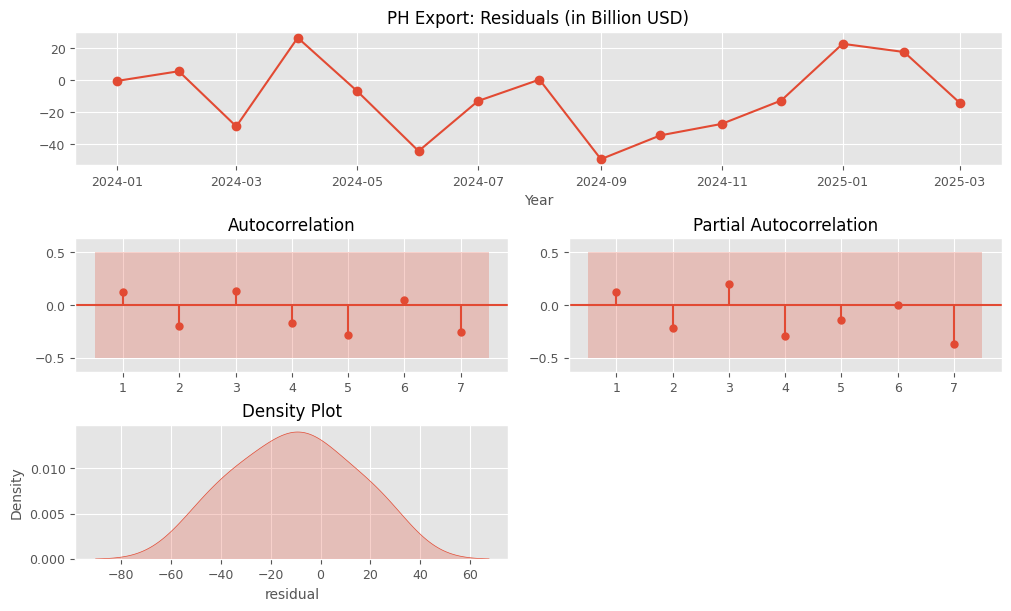

In [26]:
#### Analysis of residual
def plot_autocorr(df_in = [],
                  LAGS  = 7,
                  title = "Residuals (in Billion USD)"):

    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import seaborn as sns


    print('Table. Descriptive Statistics')
    display(df_in.describe())

    fig = plt.figure(figsize=(10,6))
    gs = fig.add_gridspec(3, 2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])

    ax1.plot(df_in, marker="o")
    ax1.set_title(title)
    ax1.set_xlabel("Year")

    sns.kdeplot(df_residuals['residual'], fill=True, ax=ax4)
    ax4.set_title('Density Plot')

    plot_acf(df_in, ax2, zero=False, lags=LAGS,
            bartlett_confint=False,
            auto_ylims=True)
    plot_pacf(df_in, ax3, zero=False, lags=LAGS,
            auto_ylims=True)
    plt.show()
    return

select = 'PHL_export'
df_residuals = fc_stats[common_cols + ['ETS_multiplicative']].merge(df_test.query('unique_id == @select'), on=['unique_id', 'ds'], how='outer')
df_residuals['residual'] = df_residuals['y'] - df_residuals['ETS_multiplicative']

#### Plot residual diagnostics
df_in = df_residuals.set_index('ds').loc[:,'residual'].dropna()
LAGS = 7
title = "PH Export: Residuals (in Billion USD)"
plot_autocorr(df_in = df_in,
                  LAGS  = LAGS,
                  title = title)

**Insights**:
* The residual analysis show that ETS model for Ph exports tends to overestimate (residual < 0).
* The forecast bias was 10 Billion USD (over-estimated).
* There were no significant correlation in the residuals suggesting that the signals were captured in the model.

Table. Descriptive Statistics


,residual
count,15.000
mean,31.811
std,39.876
min,-46.726
25%,1.456
50%,31.874
75%,54.385
max,99.575


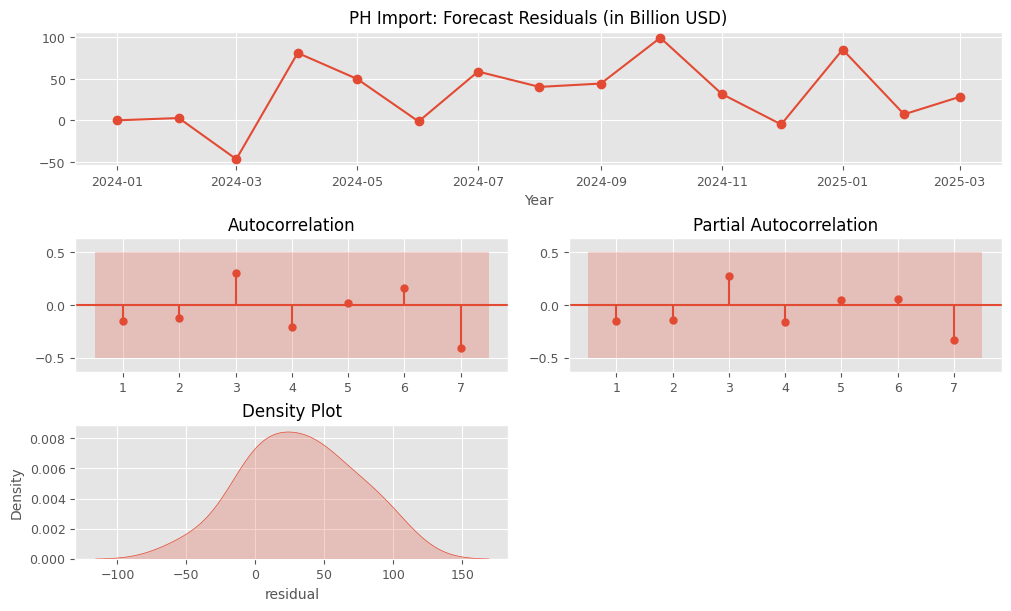

In [27]:
select = 'PHL_import'
df_residuals = fc_stats[common_cols + ['ETS_additive']].merge(df_test.query('unique_id == @select'), on=['unique_id', 'ds'], how='outer')
df_residuals['residual'] = df_residuals['y'] - df_residuals['ETS_additive']

#### Plot residual diagnostics
df_in = df_residuals.set_index('ds').loc[:,'residual'].dropna()
LAGS = 7
title = "PH Import: Forecast Residuals (in Billion USD)"
plot_autocorr(df_in = df_in,
                  LAGS  = LAGS,
                  title = title)

**Insights**:
* The residual analysis show that ETS model for Ph imports tends to overestimate (residual > 0).
* The forecast bias was 31 Billion USD (under-estimated).
* There were no significant correlation in the residuals suggesting that the signals were captured in the model.

### 6.0 Summary

* **ETS models outperformed complex ML/NN approaches** - Cross-validation results showed that Exponential Smoothing (ETS) models achieved the lowest MAE for both Philippine exports and imports, while more sophisticated models like Random Forest, LGBM, and LSTM performed worse than naive baselines, likely due to limited training data (158 observations).

* **Strong forecasting performance with reasonable directional accuracy** - The best ETS models achieved MAE of 20.4B USD for exports and 28B USD for imports, with Mean Directional Accuracy (MDA) of 66% for exports, meaning the models correctly predicted the trend direction about two-thirds of the time.

* **Robust prediction intervals capture actual values** - The ETS forecasts showed actual test values falling within the 80% prediction intervals, though import forecasts had notably wider intervals suggesting higher uncertainty in import predictions compared to exports.

* **Systematic forecast bias detected in residuals** - Residual analysis revealed that ETS models tend to overestimate exports (10B USD bias) and underestimate imports (31B USD bias), indicating potential omitted variable effects that could be addressed in future modeling.

* **No significant residual correlation suggests good signal capture** - The lack of significant autocorrelation in residuals indicates that the ETS models successfully captured the main signal components in the time series, with no remaining exploitable patterns left in the errors.

Disclaimer of AI use: Generative AI models were used to assist in coding and summarizing the discussions.

### 7.0 Appendix

#### 7.1 Cross-validation across all countries

In [28]:
start = time.time()
select = [x for x in TRAIN.unique_id.unique().tolist() if 'FX' not in x]
df_train = TRAIN.query('unique_id in @select')
df_train_aug = TRAIN_aug.query('unique_id in @select')

#### Stats and Baseline models
sf_stats = StatsForecast(stats_models, freq='MS', n_jobs=-1)
fc_stats_cv = sf_stats.cross_validation(h=HORIZON_cv,
                                         n_windows=n_windows,
                                         df=df_train,
                                         step_size=step_size)

#Dynamic Regression
# We skip DR as it raises the need to assume
# the future FX rate
# sf_dynamic = StatsForecast(dhr_models, freq='MS', n_jobs=-1)
# fc_dynamic_cv = sf_dynamic.cross_validation(h=HORIZON_cv,
#                                             n_windows=n_windows,
#                                             df=df_train_aug,
#                                             step_size=HORIZON)

#### AUTO-ARIMA models
sf_arima = StatsForecast(arima_models, freq='MS', n_jobs=-1)
fc_arima_cv = sf_arima.cross_validation(h=HORIZON_cv,
                                         n_windows=n_windows,
                                         df=df_train,
                                         step_size=step_size,
                                         #prediction_intervals=intervals,
                                         #level=[80, 95]
                                         )

#### ML MODELS
mf_cv = pd.DataFrame([])
if ml_models != []:

    mf = MLForecast(ml_models, freq="MS")
    mf_cv = mf.cross_validation(
        df=df_train_aug,
        h=HORIZON_cv,
        n_windows=n_windows,
        static_features = [],
        step_size=step_size,
    )

#### NN MODELS
nf_cv = pd.DataFrame([])
if nn_models != []:
    from neuralforecast import NeuralForecast

    nf = NeuralForecast(nn_models, freq="MS")
    nf_cv = nf.cross_validation(
        df=df_train_aug,
        n_windows=n_windows,
        step_size=step_size, # This ensures non-overlapping test sets
        refit=False # Set to True to retrain the model on each new window, but this is much slower
    )

#### Merge results
common_cols = ['unique_id', 'ds', 'cutoff', 'y']
cv_all = (fc_stats_cv
        .merge(fc_arima_cv, on=common_cols, how='outer')
        #.merge(fc_dynamic_cv, on=common_cols, how='outer')
)

if not(mf_cv.empty):
    cv_all = cv_all.merge(mf_cv, on=common_cols, how='outer')
if not(nf_cv.empty):
    cv_all = cv_all.merge(nf_cv, on=common_cols, how='outer')

print(f'Elapsed time: {time.time() - start:.2f} seconds')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | hist_encoder | LSTM             | 8.2 K  | train
----------------------------------------------------------
8.2 K     Trainable params
5         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Elapsed time: 51.25 seconds


In [29]:
#### Evaluate the cross-validated results
cv_eval = evaluate(cv_all.drop('cutoff', axis=1),
         metrics=metrics,
         train_df=df_train)

grp = (cv_eval
       .groupby('unique_id')
)
collect = []
for id, group in grp:
    best_model = (group
                .set_index('metric')
                .loc['mae',:]
                .drop('unique_id')
                .sort_values()
                .index)[0]
    entry = {'unique_id': id.split('/')[-1],
              'Best_model': best_model}
    entry.update(group[['metric', best_model]]
                 .set_index('metric')
                 .iloc[:,0]
                 .to_dict())
    collect.append(entry)

result_cv = pd.DataFrame.from_records(collect)

LOG['cv_bestmodels'] = (result_cv[['unique_id','Best_model']]
                        .set_index('unique_id')
                        .to_dict()['Best_model'])

#### display results
print('*'*75)
print('Table. CV evaluation across models by MAE')
display(cv_eval.query('metric == "mae"').T)

print('*'*75)
print('Table. Best models by MAE')
display(result_cv)

***************************************************************************
Table. CV evaluation across models by MAE


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
unique_id,AUS_export,AUS_import,CHN_export,CHN_import,HKG_export,HKG_import,IDN_export,IDN_import,IND_export,IND_import,...,SGP_export,SGP_import,THA_export,THA_import,TWN_export,TWN_import,USA_export,USA_import,VNM_export,VNM_import
metric,mae,mae,mae,mae,mae,mae,mae,mae,mae,mae,...,mae,mae,mae,mae,mae,mae,mae,mae,mae,mae
ETS_additive,153.723,62.657,816.689,593.394,119.398,140.086,105.996,81.691,106.862,255.815,...,109.279,112.796,59.51,39.878,199.668,151.783,285.348,0.0,105.332,123.005
ETS_multiplicative,152.853,51.714,1159.624,697.827,184.053,143.184,102.357,73.182,105.547,241.92,...,94.89,96.77,43.107,39.805,191.849,297.556,218.469,0.0,98.432,144.083
arima,195.361,80.594,1259.054,617.399,94.719,146.435,152.898,103.68,167.418,283.175,...,168.82,139.357,41.234,58.479,182.657,172.84,701.466,0.0,144.457,163.608
RandomForestRegressor,786.256,1160.456,13260.215,9351.884,220.393,332.97,1309.13,1471.585,509.79,610.408,...,310.729,535.772,1191.527,1282.63,480.224,870.709,6842.602,2495.917,887.694,1017.86
LGBMRegressor,758.875,1133.075,13287.596,9379.266,200.861,329.621,1281.749,1444.204,482.409,637.789,...,273.744,508.391,1164.146,1255.249,452.842,843.328,6869.984,2468.536,860.313,990.479
LSTM,269.214,104.345,1738.309,996.143,208.197,240.272,219.435,155.782,321.364,534.281,...,264.732,266.55,145.773,153.352,213.736,175.993,1121.609,0.922,144.145,160.632
LSTM-median,276.283,112.891,1822.311,995.014,204.906,239.384,203.711,161.538,332.178,568.657,...,257.545,259.455,141.106,145.868,211.25,170.187,1119.275,0.869,137.842,165.574


***************************************************************************
Table. Best models by MAE


,unique_id,Best_model,mae,mape,rmse,mase,rmsse,mda
0,AUS_export,ETS_multiplicative,152.853,9.048,165.073,0.846,0.725,0.502
1,AUS_import,ETS_multiplicative,51.714,3.934,62.793,0.457,0.439,NaN
2,CHN_export,ETS_additive,816.689,5.452,1004.501,0.704,0.650,NaN
3,CHN_import,ETS_additive,593.394,5.206,780.579,0.596,0.620,NaN
4,HKG_export,arima,94.719,4.081,138.294,0.518,0.547,NaN
5,HKG_import,ETS_additive,140.086,5.116,188.134,0.679,0.702,NaN
6,IDN_export,ETS_multiplicative,102.357,8.876,123.496,0.794,0.708,NaN
7,IDN_import,ETS_multiplicative,73.182,7.635,104.141,0.600,0.672,NaN
8,IND_export,ETS_multiplicative,105.547,5.333,124.776,0.547,0.465,NaN
9,IND_import,ETS_multiplicative,241.920,7.885,289.361,0.657,0.582,NaN


<Axes: xlabel='Best_model'>

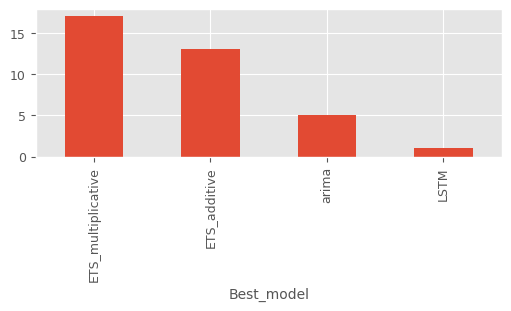

In [30]:
result_cv.Best_model.value_counts().plot(kind='bar',figsize=(5,3))

Across several countries, ETS appear to fit the imports and exports series.